In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.utils.data as data_utils
from PIL import Image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import pandas as pd
import os
from torchvision.io import read_image
import torch.nn.functional as F
from torch.optim import Adam
from os import listdir
from os.path import isfile, join
import cv2

# Creation of custom dataset to be used with pytorch

In [5]:
class ImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Definition of datasets and loaders

In [6]:
traindata = ImageDataset(annotations_file='images_split/train/labels_train.csv',img_dir='images_split/train/')
testdata = ImageDataset(annotations_file='images_split/test/labels_test.csv',img_dir='images_split/test')
valdata = ImageDataset(annotations_file='images_split/val/labels_val.csv',img_dir='images_split/val')

batch_size=5
train_loader = DataLoader(traindata, batch_size, shuffle=True,)
test_loader = DataLoader(testdata, batch_size, shuffle=True)
val_loader = DataLoader(valdata, batch_size, shuffle=True)

# Defining network architecture

In [7]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 12, 5,1,1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(12, 12, 5, 1, 1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(12,24, 5, 1, 1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(24, 24, 5, 1, 1)
        self.bn5 = nn.BatchNorm2d(24)
        self.pool2 = nn.AvgPool2d(2,2)
        self.fc1 = nn.Linear(20184, 15)

    def forward(self, input):
        x = F.relu(self.bn1(self.conv1(input.float())))      
        x = F.relu(self.bn2(self.conv2(x)))     
        x = self.pool(x)                        
        x = F.relu(self.bn4(self.conv4(x)))     
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool2(x)
        x = x.view(-1, 20184)
        x = self.fc1(x)
        x = torch.softmax(x,dim=1)

        return x

# Instantiating model

In [9]:
model = Network()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
num_epochs = 20
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14')

# Training model

In [ ]:
train_loss_list = []
val_loss_list = []
val_accuracy_list = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader, 0):
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    accuracy = correct / total
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

# Loss and accuracy plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


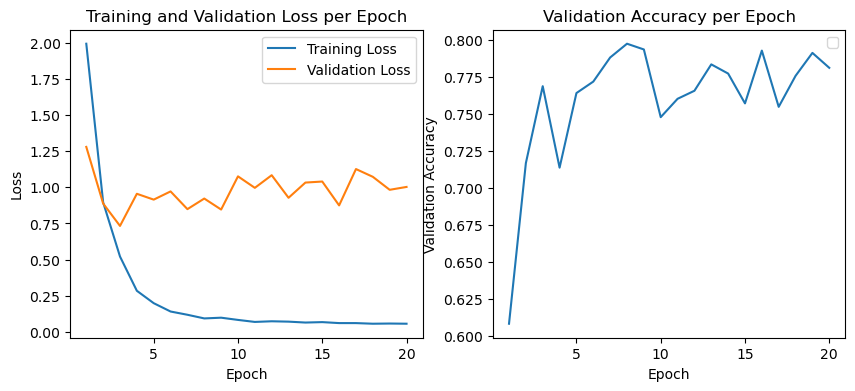

In [104]:
from matplotlib import pyplot as plt

epochs = range(1, num_epochs+1)

#Losses
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Training Loss')
plt.plot(epochs, val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()

# Validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()

plt.show()

# Test accuracy, precision and recall

In [14]:
model.eval()
tp = 0
fp = 0
fn = 0
with torch.no_grad():
    for landmarks, labels in test_loader:
        outputs = model(landmarks)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        tp += ((predicted == labels) & (predicted == 1)).sum().item()
        fp += ((predicted != labels) & (predicted == 1)).sum().item()
        fn += ((predicted != labels) & (predicted == 0)).sum().item()

accuracy_test = correct_test / total_test
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Test Accuracy: {accuracy_test:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")

Test Accuracy: 0.79250
Precision: 0.79570
Recall: 0.94872


# Test accuracy for each label

In [11]:
label_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']

correct_counts = {label: 0 for label in label_names}
total_counts = {label: 0 for label in label_names}

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        for pred_label, true_label in zip(predicted, labels):
            pred_label = pred_label.item()
            true_label = true_label.item()
            
            if pred_label == true_label:
                correct_counts[label_names[true_label]] += 1
            total_counts[label_names[true_label]] += 1

for label in label_names: 
    accuracy = correct_counts[label] / total_counts[label]
    if label == '10':
        label = 'a'
    elif label == '11':
        label = 'b'
    elif label == '12':
        label = 'c'
    elif label == '13':
        label = 'd'
    elif label == '14':
        label = 'e'
    print(f"Test Accuracy for {label}: {accuracy:.5f}")

Test Accuracy for 0: 0.79310
Test Accuracy for 1: 0.85057
Test Accuracy for 2: 0.65517
Test Accuracy for 3: 0.85057
Test Accuracy for 4: 0.79310
Test Accuracy for 5: 0.82759
Test Accuracy for 6: 0.59770
Test Accuracy for 7: 0.71264
Test Accuracy for 8: 0.56322
Test Accuracy for 9: 0.90805
Test Accuracy for a: 0.81609
Test Accuracy for b: 0.81818
Test Accuracy for c: 0.93103
Test Accuracy for d: 0.87356
Test Accuracy for e: 0.89655


# Saving model

In [103]:
torch.save(model.state_dict(), 'hands_model_cnn_no_soft.pth')

# Making predictions for each image

In [ ]:
from matplotlib import pyplot as plt

coord = []
lista = []
for i in os.listdir("images_split/test"):  
    
    if i.endswith(".jpg"):
        path = os.path.join("images_split/test", i)
        model.eval()

        with torch.no_grad():
            for images, labels in test_loader:
                output = model(images)

        probabilities = torch.softmax(output, dim=1)
        _, predicted_class = torch.max(probabilities, dim=1)
        print("Class predicted:", predicted_class.item())
        im = cv2.imread(path)
        im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        plt.imshow(im_rgb)
        plt.axis('off')
        plt.show()